In [1]:
import sys
import matplotlib as mpl
mpl.use('Agg')
sys.path.append('..')
from tools.brushstroke.fractal import gen
from tools.brushstroke.common import load_model
from IPython.display import Image

Couldn't import dot_parser, loading of dot files will not be possible.


/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
model_a, data, layers = load_model("../training/fractal/b/model.pkl")
model_b, data, layers = load_model("../training/fractal/b2/model.pkl")
model_c, data, layers = load_model("../training/fractal/a6/model.pkl")

(None, 1, 8, 8)
Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 64))
loaded
(128, 128, (128000, 64))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 8, 8)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 16, 16)
Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 256))
loaded
(128, 128, (128000, 256))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 16, 16)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 32, 32)
Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 32, 32)
Compiling the model...


INFO:tasks:Compiling the model...


In [17]:
neuralnets = [
    {'model': model_a, 
     'on': 'crops', 
     'padlen': 3,   
     'nb_iter':  1,   
     'thresh': 'moving', 
     'when': 'always', 
     'whitepx_ratio': 0.2},
    
    {'model': model_b, 
     'on': 'crops', 
     'padlen': 3,  
     'nb_iter':  1,   
     'thresh': 'moving', 
     'when': 'always', 
     'whitepx_ratio': 0.2},

]


neuralnets.append(
    {'model': model_c, 
     'on': 'crops', 
     'padlen': 3,   
     'nb_iter':  1,   
      'inner_padlen': 3,
     'thresh': 'moving', 
     'when': 'always', 
     'whitepx_ratio': 0.2}
)



In [18]:
img, snap = gen(neuralnets, nb_iter=1000, w=2**6, h=2**6, init='random', out='manual.png')

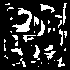

In [19]:
Image('manual.png')